# Proyek Klasifikasi Gambar: [Plant Village Dataset : Detection Plant Disease]
- **Nama:** Reynaldo Arya Budi Trisna
- **Email:** reynaldstar@gmail.com
- **ID Dicoding:** reynaldoabt

## Import Semua Packages/Library yang Digunakan

In [ ]:
# Install required packages
!pip install tensorflow tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 78.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully unin

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import PIL
import pathlib

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflowjs as tfjs

## Data Preparation

In [5]:
import os
import json

# Create kaggle config directory
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

# Save kaggle.json content
kaggle_config = {
    "username": "reynaldoarya",
    "key": "15e910ed39a7c2a7c18a4b59e00131bf"
}

with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump(kaggle_config, f)

# Set appropriate permissions
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

In [6]:
# Download dataset
!kaggle datasets download -d abdallahalidev/plantvillage-dataset -p /content/plant_village --unzip

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
100% 2.04G/2.04G [00:13<00:00, 231MB/s]
100% 2.04G/2.04G [00:13<00:00, 166MB/s]


### Data Loading

In [8]:
# Verify directory contents
print("Available datasets:")
!ls /content/plant_village/plantvillagedataset/

# Set paths for each version
color_dir = pathlib.Path("/content/plant_village/plantvillagedataset/color")
grayscale_dir = pathlib.Path("/content/plant_village/plantvillagedataset/grayscale")
segmented_dir = pathlib.Path("/content/plant_village/plantvillagedataset/segmented")

# We'll use color version for our model
data_dir = color_dir

print("\nContents of color dataset:")
!ls {str(data_dir)}

Available datasets:
color  grayscale  segmented

Contents of color dataset:
 Apple___Apple_scab
 Apple___Black_rot
 Apple___Cedar_apple_rust
 Apple___healthy
 Blueberry___healthy
'Cherry_(including_sour)___healthy'
'Cherry_(including_sour)___Powdery_mildew'
'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
'Corn_(maize)___Common_rust_'
'Corn_(maize)___healthy'
'Corn_(maize)___Northern_Leaf_Blight'
 Grape___Black_rot
'Grape___Esca_(Black_Measles)'
 Grape___healthy
'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'
'Orange___Haunglongbing_(Citrus_greening)'
 Peach___Bacterial_spot
 Peach___healthy
 Pepper,_bell___Bacterial_spot
 Pepper,_bell___healthy
 Potato___Early_blight
 Potato___healthy
 Potato___Late_blight
 Raspberry___healthy
 Soybean___healthy
 Squash___Powdery_mildew
 Strawberry___healthy
 Strawberry___Leaf_scorch
 Tomato___Bacterial_spot
 Tomato___Early_blight
 Tomato___healthy
 Tomato___Late_blight
 Tomato___Leaf_Mold
 Tomato___Septoria_leaf_spot
'Tomato___Spider_mites Two-spott

In [9]:
# Verify directory contents
data_dir = pathlib.Path("/content/plant_village/plantvillagedataset/color")

In [10]:
# Print image resolution and count
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            image_files = [f for f in os.listdir(subdir_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            num_images = len(image_files)
            print(f"{subdir}: {num_images}")
            total_images += num_images

            for img_file in image_files[:5]:
                img_path = os.path.join(subdir_path, img_file)
                with PIL.Image.open(img_path) as img:
                    unique_sizes.add(img.size)

    print("\nUnique image sizes:")
    for size in unique_sizes:
        print(f"- {size}")
    print(f"\nTotal images: {total_images}")

print("Dataset Information:")
print_images_resolution(str(data_dir))

# Get class names
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != ".DS_Store"]))
print(f"\nTotal Classes: {len(class_names)}")
print("\nClasses:")
for idx, name in enumerate(class_names, 1):
    print(f"{idx}. {name}")

Dataset Information:
Tomato___Bacterial_spot: 2127
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076
Pepper,_bell___Bacterial_spot: 997
Tomato___Septoria_leaf_spot: 1771
Orange___Haunglongbing_(Citrus_greening): 5507
Peach___Bacterial_spot: 2297
Tomato___Late_blight: 1909
Grape___Black_rot: 1180
Potato___healthy: 152
Tomato___Target_Spot: 1404
Potato___Late_blight: 1000
Apple___healthy: 1645
Pepper,_bell___healthy: 1478
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 5357
Cherry_(including_sour)___Powdery_mildew: 1052
Squash___Powdery_mildew: 1835
Raspberry___healthy: 371
Corn_(maize)___healthy: 1162
Blueberry___healthy: 1502
Soybean___healthy: 5090
Tomato___Leaf_Mold: 952
Corn_(maize)___Northern_Leaf_Blight: 985
Grape___healthy: 423
Tomato___Early_blight: 1000
Grape___Esca_(Black_Measles): 1383
Tomato___Tomato_mosaic_virus: 373
Apple___Black_rot: 621
Tomato___healthy: 1591
Tomato___Spider_mites Two-spotted_spider_mite: 1676
Strawberry___healthy: 456
Potato___Early_blight: 1000
Corn_(maize)___C

### Data Preprocessing

In [11]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

In [16]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation
test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

#### Split Dataset

In [17]:
# Load train dataset (80%)
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Load validation dataset (20%)
validation_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


## Modelling

In [18]:
model = models.Sequential([
    # First Convolution Block
    layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Second Convolution Block
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Third Convolution Block
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Fourth Convolution Block
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Dense Layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

# Train model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,888,262 (102.57 MB)

 Trainable params: 26,885,318 (102.56 MB)

 Non-trainable params: 2,944 (11.50 KB)

Epoch 1/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 637s 457ms/step - accuracy: 0.4671 - loss: 2.0596 - val_accuracy: 0.2817 - val_loss: 5.2900
Epoch 2/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 620s 454ms/step - accuracy: 0.7643 - loss: 0.7578 - val_accuracy: 0.6668 - val_loss: 1.5159
Epoch 3/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 619s 454ms/step - accuracy: 0.8421 - loss: 0.4928 - val_accuracy: 0.5789 - val_loss: 2.1707
Epoch 4/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 615s 449ms/step - accuracy: 0.8822 - loss: 0.3649 - val_accuracy: 0.7836 - val_loss: 0.9333
Epoch 5/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 631s 455ms/step - accuracy: 0.9083 - loss: 0.2898 - val_accuracy: 0.8568 - val_loss: 0.4578


## Evaluasi dan Visualisasi

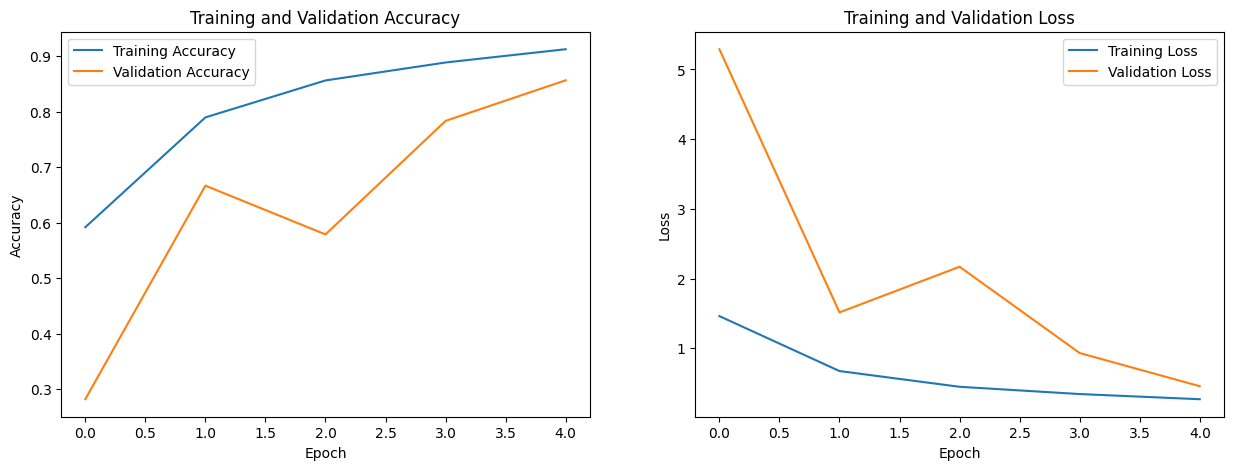


Final Training Accuracy: 0.9128
Final Validation Accuracy: 0.8568


In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print final metrics
final_train_accuracy = acc[-1]
final_val_accuracy = val_acc[-1]
print(f'\nFinal Training Accuracy: {final_train_accuracy:.4f}')
print(f'Final Validation Accuracy: {final_val_accuracy:.4f}')

## Konversi Model

In [21]:
import os
import tensorflow as tf
import tensorflowjs as tfjs

# Buat struktur direktori untuk menyimpan model
os.makedirs('/content/drive/MyDrive/submission2/saved_model', exist_ok=True)
os.makedirs('/content/drive/MyDrive/submission2/tflite_model', exist_ok=True)
os.makedirs('/content/drive/MyDrive/submission2/tfjs_model', exist_ok=True)

# 1. Save as SavedModel
# Simpan model dalam format SavedModel menggunakan export
model.export('/content/drive/MyDrive/submission2/saved_model')

# 2. Convert to TF-Lite
# Konversi model SavedModel ke format TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/MyDrive/submission2/saved_model')
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open('/content/drive/MyDrive/submission2/tflite_model/model.tflite', 'wb') as f:
    f.write(tflite_model)

# Simpan label kelas ke file
class_names = list(train_generator.class_indices.keys())
with open('/content/drive/MyDrive/submission2/tflite_model/labels.txt', 'w') as f:
    for class_name in class_names:
        f.write(f'{class_name}\n')

# 3. Convert to TensorFlow.js
# Konversi model ke format TensorFlow.js
tfjs.converters.save_keras_model(model, '/content/drive/MyDrive/submission2/tfjs_model')

# 4. Buat file requirements.txt
# Simpan daftar dependensi Python ke file requirements.txt
!pip freeze > /content/drive/MyDrive/submission2/requirements.txt


Saved artifact at '/content/drive/MyDrive/submission2/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_30')
Output Type:
  TensorSpec(shape=(None, 38), dtype=tf.float32, name=None)
Captures:
  137288665710832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137288665715760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137288665724032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137288665724912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137288665719456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137288665721744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137288665726320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137288665725440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137288665745360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137288665746416: TensorSpec(shape=(), dtype=tf.res

failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

In [22]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import TFSMLayer

def predict_image(image_path, model, class_names, img_height=224, img_width=224):
    """
    Predict the class of an image using a trained model.

    Args:
        image_path (str): Path to the image file.
        model (tf.keras.layers.Layer): Trained TFSMLayer model.
        class_names (list): List of class names.
        img_height (int): Height of the input image for the model.
        img_width (int): Width of the input image for the model.

    Returns:
        None: Displays the image and prints the predicted class.
    """
    # Load and preprocess the image
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]

    # Make predictions using TFSMLayer
    predictions = model(img_array)  # Call the TFSMLayer directly

    # Handle dictionary output
    if isinstance(predictions, dict):
        # Access the first key (usually 'output_0' or 'default')
        predictions = predictions[list(predictions.keys())[0]]

    # Convert Tensor to NumPy array
    predictions = predictions.numpy()
    predicted_class_index = np.argmax(predictions[0])  # Get the index of the highest probability
    confidence = predictions[0][predicted_class_index]  # Get the confidence score

    # Debugging confidence value
    print(f"Confidence raw value: {confidence}")  # Check the value of confidence

    # Ensure confidence is a float
    if isinstance(confidence, (np.ndarray, dict)):
        confidence = float(np.max(predictions[0]))  # Convert to float

    # Display the image and prediction
    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_class_index]} ({confidence:.2%})")
    plt.axis('off')
    plt.show()

    print(f"Predicted class: {class_names[predicted_class_index]}")
    print(f"Confidence: {confidence:.2%}")

Confidence raw value: 0.9961548447608948


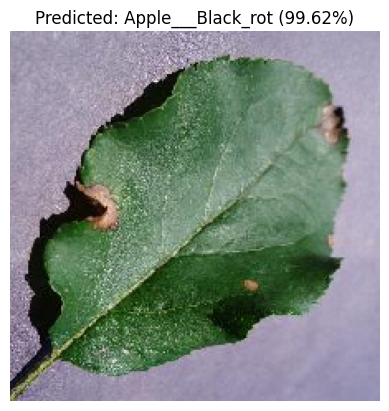

Predicted class: Apple___Black_rot
Confidence: 99.62%


In [24]:
from keras.layers import TFSMLayer

# Path ke gambar yang ingin diprediksi
image_path = '/content/drive/MyDrive/test/test1.JPG'

# Muat model menggunakan TFSMLayer
model = TFSMLayer('/content/drive/MyDrive/submission2/saved_model', call_endpoint='serving_default')

# Muat daftar nama kelas
class_names = list(train_generator.class_indices.keys())

# Lakukan prediksi
predict_image(image_path, model, class_names)